100%|██████████| 170498071/170498071 [00:47<00:00, 3552123.53it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


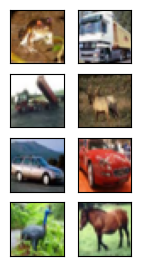

In [1]:
import os
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import pandas as pd


#######################################
# Train model with image augmentation #
#######################################

all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_images[i][0] for i in range(8)], 4, 2, scale=0.8);

loss 0.389, train acc 0.829, test acc 0.853
1970.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


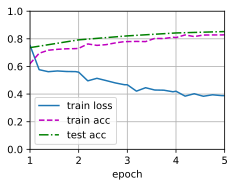

: 

In [5]:
import os
import torch
from torch import nn
import torchvision
from torchvision import transforms
from d2l import torch as d2l

# Prepare the data
data_dir = d2l.download_extract('hotdog')

# Normalize with the pre-computed ImageNet mean and std
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Define augmentations
train_augs = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_augs = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

# DataLoader
train_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs),
    batch_size=128, shuffle=True)
test_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
    batch_size=128)

# Fine-tune ResNet-18
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

# Freeze parameters
for param in finetune_net.parameters():
    param.requires_grad = False

# Enable training only for the output layer
finetune_net.fc.weight.requires_grad = True
finetune_net.fc.bias.requires_grad = True

# Trainer
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5):
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.SGD(net.fc.parameters(), lr=learning_rate, weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

# Start training
train_fine_tuning(finetune_net, 5e-5)


loss 0.182, train acc 0.926, test acc 0.939
1002.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


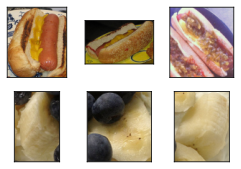

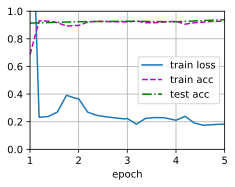

In [2]:
###############
# Fine-tuning #
###############

d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))
len(train_imgs)      # 2000
len(test_imgs)       # 800 

# Show images of hotdogs and not hotdogs
hotdogs = [train_imgs[i][0] for i in range(3)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(3)]   # last three images
d2l.show_images(hotdogs + not_hotdogs, 2, 3, scale=1.4);

# Specify the means and standard deviations of e three RGB channels to standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Using the mean and std of Imagenet is a common practice. They are calculated 
# based on millions of images. If you want to train from scratch on your own 
# dataset, you can calculate the new mean and std. Otherwise, using Imagenet 
# pretrained model with its own mean and std is recommended. 

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(), normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(), normalize])


# If `param_group=True`, parameters in output layer are updated using learning rate 10 times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs), batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs), batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters() # all parameters not in output layer
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(),
                  'lr': learning_rate * 10}], lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
    
# Fine-tuning
# pretrained_net = torchvision.models.resnet18(pretrained=True)
# pretrained_net.fc                                             # imagenet has 1000 classes
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)   # change no. of classes to 2
nn.init.xavier_uniform_(finetune_net.fc.weight);
train_fine_tuning(finetune_net, 5e-5)  # output layer lr: 5e-4, remaining lr: 5e-5

loss 0.379, train acc 0.875, test acc 0.912
1978.2 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


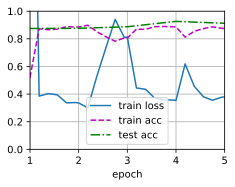

In [3]:
"""
another version:
Set the parameters before the output layer of finetune_net to those of the source model 
and do not update them during training.
Use the same settings as in Section 10.2.1 for training and a learning rate of 5e-5
"""
def train_frozening(net, learning_rate, batch_size=128, num_epochs=5):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs), batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs), batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    params_1x = [param for name, param in net.named_parameters() # all parameters not in output layer
            if name not in ["fc.weight", "fc.bias"]]
    # frozening all parameters except output layer, we use the above (original) params_1x to freeze
    for param in params_1x:
        param.requires_grad = False
    trainer = torch.optim.SGD([{'params': net.fc.parameters(),
                'lr': learning_rate * 10}], lr=learning_rate, weight_decay=0.001)

    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
    
# Fine-tuning
finetune_net_frozen = torchvision.models.resnet18(pretrained=True)
finetune_net_frozen.fc = nn.Linear(finetune_net_frozen.fc.in_features, 2)   # change no. of classes to 2
nn.init.xavier_uniform_(finetune_net_frozen.fc.weight);
train_frozening(finetune_net_frozen, 5e-5)